## Nonlinear pulse propagation

From Hamerly's paper.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [6]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

In [7]:
#Input parameters
la = 1.5 #um
lb = la/2 #um
L = 40 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5 !?
a0 = 10

p = 1.1 #normalized power
l = 0 #detuning

### Pump

Gaussian pulse:
$$A(t) = exp(-t^2/t_p^2)$$

$$t_p = \frac{t_d}{\sqrt{4 \log{2}}}$$

Sampling Rate = 0.12903225806451246 ps


<IPython.core.display.Javascript object>


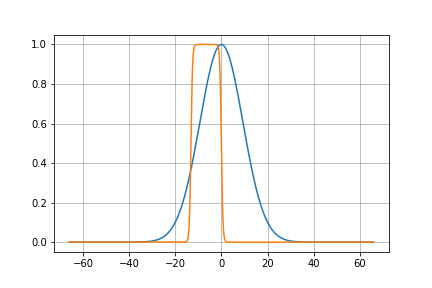

In [12]:
#tp = td/np.sqrt(4*np.log(2)) #tp for Gaussian pulse

N = 1024 #Fourier size
xtra = 5
t = np.linspace(-xtra*Tp, xtra*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')
Omega = 2*pi*np.fft.fftfreq(t.size, ts)

# b = p*b0*np.exp(-t**2/Tp**2)
Tp1 = -Tp
Tp2 =  0
b_shape = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
a_shape = np.exp(-t**2/(Tp)**2)

plt.plot(t,a_shape,t,b_shape)
plt.grid()

# b = p*b0*b
# plt.figure()
# plt.plot(t,a)

### Propagation

In [9]:
h = 0.1 #Distance step Size

#Linear operator (Waveguide)
Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h/2)
Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h/2)

In [10]:
def single_pass(a,b,Da,Db,L,h):
    zi = 0
    while zi<L:
        #Linear half step (front)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Nonlinear step
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)

        #Integral for b
        b = b - 0.5*h*epsilon*a*a
        
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        
        #Linear half step (back)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Next z
        zi = zi+h
    return a,b

## OPO

<IPython.core.display.Javascript object>


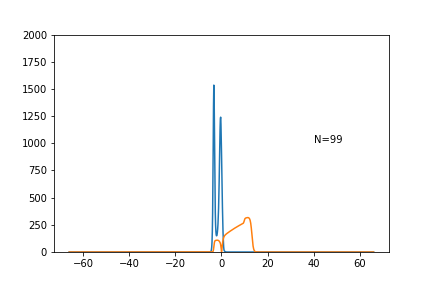

In [13]:
N = 100 #loops
a = a_shape

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

for kn in range(N):
    b = b0*p*b_shape
    a,b = single_pass(a,b,Da,Db,L,h)

    ax.clear()
    ax.plot(t, abs(a), t, abs(b));
    ax.axes.set_ylim(0,2000)
    ax.text(40,1000,'N=' + str(kn))
    fig.canvas.draw()
    time.sleep(0.001)
    
    #Feedback loop
#     a = a/np.sqrt(G0)
    a = a/1.5